In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import mlflow 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
from optbinning import OptimalBinning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import f_oneway
warnings.filterwarnings('ignore')

csvs = [i for i in os.listdir() if '.csv' in i]
feature_df = pd.read_csv('./var_analysis.csv')
feature_df.head()


,Unnamed: 0,Bucket Range,Records,Records (%),High Risk Ratio,Low Risk Ratio,WoE,col_name
0,1,"(-inf, 0.50)","1,781,105",8.02,22.91,77.09,-1.3006435209639389,ACTV_30_DYS_avg
1,2,"[0.50, 1.00)","904,401",4.07,19.14,80.86,-1.0734696541841595,ACTV_30_DYS_avg
2,3,"[1.00, inf)","19,287,915",86.87,4.61,95.39,0.5148297817279093,ACTV_30_DYS_avg
3,4,Missing,"228,985",1.03,83.56,16.44,-4.140236066600819,ACTV_30_DYS_avg
4,Totals,,"22,202,406",100.00,7.49,92.51,,ACTV_30_DYS_avg


In [19]:


def prob_return(num):
    a = 2
    b = 2
    mu = 0
    sigma = 0.5
    # return np.random.beta(a, b, size=num)
    # normal = np.random.normal(0, 1, num)
    # normal = norm.cdf(normal)
    # return normal
    return abs(np.random.normal(mu, sigma, num))

random.seed(10)
def generate_data(num):
    df = pd.DataFrame({'party_id':[i for i in range(num)],
                      'risk_probability': [random.uniform(a = 0, b = 1) for i in range(num)]
                      })
    
    df['high_risk_flag'] = [0 if i<0.50 else 1 for i in df['risk_probability']]
    ##################### BILL  ##############################
    df['BILL_OUTSTANDING_M1_avg'] = 5000*(df['risk_probability'] + prob_return(num) )
    df['BILL_AMT_M1_avg'] = 4000*(df['risk_probability'] + prob_return(num) )
    df['BILL_RENTALS_M1_avg'] = 700*(df['risk_probability'] + prob_return(num) )
    df['BILL_RENTALS_M2_avg'] = 1700*(df['risk_probability'] + prob_return(num) )
    df['BILL_RENTALS_M3_avg'] = 1600*(df['risk_probability'] + prob_return(num) )
    df['BILL_RENTALS_M4_avg'] = 400*(df['risk_probability'] + prob_return(num) )
    df['BILL_RENTALS_M5_avg'] = 350*(df['risk_probability'] + prob_return(num) )
    df['BILL_RENTALS_M6_avg'] = 400*(df['risk_probability'] + prob_return(num) )
    df['BILL_USAGE_CHRGS_M1_avg'] = 0.02*(df['risk_probability'] + prob_return(num) )
    df['BILL_USAGE_CHRGS_M2_avg'] = 0.2*(df['risk_probability'] + prob_return(num) )
    df['BILL_USAGE_CHRGS_M3_avg'] = 0.2*(df['risk_probability'] + prob_return(num) )
    df['BILL_USAGE_CHRGS_M4_avg'] = 0.15*(df['risk_probability'] + prob_return(num) )
    df['BILL_USAGE_CHRGS_M5_avg'] = 1300*(df['risk_probability'] + prob_return(num) )
    df['BILL_USAGE_CHRGS_M6_avg'] = 1400*(df['risk_probability'] + prob_return(num) )
    df['BILL_OUTSTANDING_M1_sum'] = 5000*(df['risk_probability'] + prob_return(num) )
    df['BILL_OUTSTANDING_M3_avg'] = 3500*(df['risk_probability'] + prob_return(num) )
    df['BILL_OUTSTANDING_M3_sum'] = 7000*(df['risk_probability'] + prob_return(num) )
    df['BILL_OUTSTANDING_M6_avg'] = 3000*(df['risk_probability'] + prob_return(num) )
    df['BILL_OUTSTANDING_M6_sum'] = 4000*(df['risk_probability'] + prob_return(num) )
    ########### ACTV ##############
    df['ACTV_30_DYS_avg'] = df['risk_probability'] + prob_return(num)
    df['ACTV_60_DYS_avg'] = df['risk_probability'] + prob_return(num)
    df['ACTV_90_DYS_avg'] = df['risk_probability'] + prob_return(num)
    df['ACTV_30_DYS_norm'] = 50*(df['risk_probability'] + prob_return(num))
    df['ACTV_60_DYS_norm'] = 100*(df['risk_probability'] + prob_return(num))
    df['ACTV_90_DYS_norm'] = 25*(df['risk_probability'] + prob_return(num))
    
    ########### ARPU #################
    df['ARPU_12_avg'] = 350*(df['risk_probability'] + prob_return(num))
    df['ARPU_1_avg'] = 3000*(df['risk_probability'] + prob_return(num))
    df['ARPU_3_avg'] = 150*(df['risk_probability'] + prob_return(num))
    df['ARPU_6_avg'] = 2000*(df['risk_probability'] + prob_return(num))
    df['ARPU_12_sum'] = 200*(df['risk_probability'] + prob_return(num))
    df['ARPU_1_sum'] = 325*(df['risk_probability'] + prob_return(num))
    df['ARPU_3_sum'] = 150*(df['risk_probability'] + prob_return(num))
    df['ARPU_6_sum'] = 3500*(df['risk_probability'] + prob_return(num))
    df
    ############# FLG ##############
    df['BAR_FLG_M6_N_norm'] = 97*(df['risk_probability'] + prob_return(num))
    df['BAR_FLG_M6_Y_norm'] = 52*(df['risk_probability'] + prob_return(num))
    df['BAR_FLG_N_norm'] = 1*(df['risk_probability'] + prob_return(num))
    df['BAR_FLG_Y_norm'] = 1*(df['risk_probability'] + prob_return(num))
    df['CC_CARD_FLG_count']  = 1*(df['risk_probability'] + prob_return(num))
    df['CST_CAT_FLG_EP_norm'] = 73*(df['risk_probability'] + prob_return(num))
    df['CST_CAT_FLG_NP_norm'] = 87*(df['risk_probability'] + prob_return(num))
    df['PORTIN_N_FLG_count'] = 0.5*(df['risk_probability'] + prob_return(num))
    df['PORTIN_N_FLG_norm'] = 86*(df['risk_probability'] + prob_return(num))
    df['PORTIN_Other_FLG_count'] = 1*(df['risk_probability'] + prob_return(num))
    df['PORTIN_Other_FLG_norm'] = 1*(df['risk_probability'] + prob_return(num))
    df['PORTIN_Y_FLG_count'] = 1*(df['risk_probability'] + prob_return(num))
    df['PORTIN_Y_FLG_norm'] = 1*(df['risk_probability'] + prob_return(num))
    df['PORTOUT_N_FLG_count'] = 0.5*(df['risk_probability'] + prob_return(num))
    df['PORTOUT_N_FLG_norm'] = 86*(df['risk_probability'] + prob_return(num))
    df['PORTOUT_Other_FLG_count'] = 1*(df['risk_probability'] + prob_return(num))
    df['PORTOUT_Other_FLG_norm'] = 1*(df['risk_probability'] + prob_return(num))
    df['PORTOUT_Y_FLG_count'] = 1*(df['risk_probability'] + prob_return(num))
    df['PORTOUT_Y_FLG_norm'] = 1*(df['risk_probability'] + prob_return(num))
    
    
    ############## VO #############
    df['VO_MOB_MOU_FREE_M1'] = 13500*(df['risk_probability'] + prob_return(num))
    df['VO_MOB_MOU_OFFNT_M1'] = 3156*(df['risk_probability'] + prob_return(num))
    df['VO_MOB_MOU_ONNT_M1'] = 15500*(df['risk_probability'] + prob_return(num))
    
    ############ PORT #############
    df['MNP_PORT_IN_0_count'] = prob_return(num)
    df['MNP_PORT_OUT_0_count'] = prob_return(num)
    df['MNP_PORT_IN_1_count'] = prob_return(num)
    df['MNP_PORT_OUT_1_count'] =prob_return(num)
    df['MNP_PORT_IN_0_norm'] = prob_return(num)
    df['MNP_PORT_OUT_0_norm'] =prob_return(num)
    df['MNP_PORT_IN_1_norm'] = prob_return(num)
    df['MNP_PORT_OUT_1_norm'] =prob_return(num)
    
    df['PORTIN_N_FLG_count']=0.5*(df['risk_probability'] + prob_return(num))
    df['PORTIN_N_FLG_norm']=86*(df['risk_probability'] + prob_return(num))
    df['PORTIN_Y_FLG_count'] =prob_return(num)
    df['PORTIN_Y_FLG_norm']=prob_return(num)
    df['PORTIN_Other_FLG_count']=prob_return(num)
    df['PORTIN_Other_FLG_norm']=prob_return(num)
    
    
    df['PORTOUT_N_FLG_count']=0.5*(df['risk_probability'] + prob_return(num))
    df['PORTOUT_N_FLG_norm']=86*(df['risk_probability'] + prob_return(num))
    df['PORTOUT_Y_FLG_count'] =prob_return(num)
    df['PORTOUT_Y_FLG_norm']=prob_return(num)
    df['PORTOUT_Other_FLG_count']=prob_return(num)
    df['PORTOUT_Other_FLG_norm']=prob_return(num)
    
    ####### CST ################
    df['CST_BAD_DEBT_AMT'] = 6200*(df['risk_probability'] + prob_return(num))
    df['CST_BAD_DEBT_RATIO'] = 700*(df['risk_probability'] + prob_return(num))
    df['CST_BILL_AMT_M1']  = 6500*(df['risk_probability'] + prob_return(num))
    
    
    df['OS_TO_PMNT_RATIO_avg']  = 3000*(df['risk_probability'] + prob_return(num))
    df['OS_TO_PMNT_RATIO_norm']  = 317000*(df['risk_probability'] + prob_return(num))
    df['PMNT_AMT_M1_avg']  = 1500*(df['risk_probability'] + prob_return(num))
    df['PMNT_AMT_M1_sum']  = 3500*(df['risk_probability'] + prob_return(num))
    df['PMNT_CHNL_CNT_M1_max']  = 1.5*(df['risk_probability'] + prob_return(num))
    df['PMNT_CNT_M1_avg']  = 1.03*(df['risk_probability'] + prob_return(num))
    df['PMNT_CNT_M1_max']  = 1.5*(df['risk_probability'] + prob_return(num))
    df['TOP_CHNL_TOT_PMNT_RAT_M1_avg']  = 1.53*(df['risk_probability'] + prob_return(num))
    
    df['FNP_portin_count'] = abs(10*np.random.normal(size = num)).astype(int)
    df['FNP_portin_norm'] = abs(10*np.random.normal(size = num)).astype(int)
    df['FNP_portout_count'] = abs(10*np.random.normal(size = num)).astype(int)
    df['FNP_portout_norm'] = abs(10*np.random.normal(size = num)).astype(int)
    df = create_categorical(df, ['GOV-SALES-VIP-AUH','Growth','Unknown','Missing'], 'CST_CORP_SEG_mode')
    df = create_categorical(df, ['1*STAR','4*STAR','2*STAR','PRSTG_MGMT','PRESTIGE','3*STAR','NEW CUST','5*STAR','Unknown','DORMANT','Missing'], 'CST_PFT_ARPU_BAND_mode')
    df = create_categorical(df, ['None', 'EMIRATI BRONZE','UNIDENTIFIED', 'PRESTIGE BY MGMT', 'BRONZE','VVVIP', 'GOLD_SPECIAL_NEEDS', 'EMIRATI GOLD', 'PRESTIGE PLATINUM', 'PRESTIGE Ana Emirati', 'EMIRATI SILVER','EMIRATI WELCOME', 'PRESTIGE SOLITAIRE', 'SILVER', 'GOLD', 'WELCOME','YOUTH', 'Missing'] , 'CST_PFT_ARPU_SEG_mode')
    df = create_categorical(df, ['CONSUMER'], 'CST_SEG_TP_mode')
    df = create_categorical(df, ['Diamond','Unknown','Platinum','Gold'], 'CST_VAL_SEG_mode')
    df = create_categorical(df, ['Unknown', 'BankAdvice', 'Cheque', 'Card', 'Mix', 'Wallet', 'Cash', 'Loyalty', 'None'],'PMNT_TOP_CHNL_M1_mode') 

    return df



def create_categorical(df, pop_vals, col_name):
    le = LabelEncoder()
    le.fit(pop_vals)
    le.transform(pop_vals)
    noisy_probs = (df['risk_probability'] + np.random.beta(10,11,size = len(df)) )
    noisy_probs = [0.99 if i>1 else i for i in noisy_probs]
    values = [int(i*len(pop_vals)) for i in noisy_probs]
    transformed = le.inverse_transform(values)
    df[col_name]  = transformed
    return df





In [24]:
df = generate_data(1000)
df

,party_id,risk_probability,high_risk_flag,BILL_OUTSTANDING_M1_avg,BILL_AMT_M1_avg,BILL_RENTALS_M1_avg,BILL_RENTALS_M2_avg,BILL_RENTALS_M3_avg,BILL_RENTALS_M4_avg,BILL_RENTALS_M5_avg,...,FNP_portin_count,FNP_portin_norm,FNP_portout_count,FNP_portout_norm,CST_CORP_SEG_mode,CST_PFT_ARPU_BAND_mode,CST_PFT_ARPU_SEG_mode,CST_SEG_TP_mode,CST_VAL_SEG_mode,PMNT_TOP_CHNL_M1_mode
0,0,0.687174,1,7123.668909,4663.789820,966.335694,1944.551130,1135.481999,477.472920,312.432436,...,2,24,2,9,Unknown,Unknown,YOUTH,CONSUMER,Unknown,Wallet
1,1,0.385514,0,3785.304120,3664.043084,1065.715578,880.293810,814.829360,471.812433,192.231955,...,3,22,11,9,Unknown,PRSTG_MGMT,VVVIP,CONSUMER,Unknown,None
2,2,0.236913,0,7082.362170,2331.925842,457.298077,1182.726736,574.722476,134.714775,98.219864,...,3,0,13,0,Missing,NEW CUST,UNIDENTIFIED,CONSUMER,Unknown,Unknown
3,3,0.432247,0,2364.175138,2627.134204,435.788853,1088.093911,1410.607154,226.272499,297.466951,...,3,6,12,3,Unknown,Unknown,YOUTH,CONSUMER,Unknown,Wallet
4,4,0.548772,1,2755.668123,2764.048663,934.216990,1687.627869,1154.245113,453.157910,233.169285,...,14,3,10,3,Unknown,PRSTG_MGMT,VVVIP,CONSUMER,Unknown,Wallet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,0.946381,1,5685.141390,6824.385204,852.925524,1626.997247,2119.273333,449.642524,514.785611,...,2,7,7,0,Unknown,Unknown,YOUTH,CONSUMER,Unknown,Wallet
996,996,0.631983,1,5475.744592,2695.385065,806.715498,2049.013124,1410.353970,472.488463,385.258003,...,3,5,15,8,Unknown,Unknown,YOUTH,CONSUMER,Unknown,Wallet
997,997,0.809294,1,7893.916132,6486.583464,1106.573133,1417.938502,1758.868461,434.391715,310.754123,...,5,14,4,3,Unknown,Unknown,YOUTH,CONSUMER,Unknown,Wallet
998,998,0.822346,1,5500.194177,4091.974527,1339.293780,1834.116194,1850.196641,374.908748,489.792412,...,2,26,9,17,Unknown,Unknown,YOUTH,CONSUMER,Unknown,Wallet


In [563]:
df.groupby(variable).agg({'high_risk_flag':['mean','std']})

high_risk_flag          
                                mean       std
CST_PFT_ARPU_SEG_mode                         
EMIRATI WELCOME             0.000000       NaN
GOLD                        0.000000  0.000000
GOLD_SPECIAL_NEEDS          0.000000  0.000000
Missing                     0.000000  0.000000
None                        0.000000  0.000000
PRESTIGE Ana Emirati        0.000000  0.000000
PRESTIGE BY MGMT            0.000000  0.000000
PRESTIGE PLATINUM           0.000000  0.000000
PRESTIGE SOLITAIRE          0.000000  0.000000
SILVER                      0.014981  0.121706
UNIDENTIFIED                0.063604  0.244479
VVVIP                       0.140984  0.348577
WELCOME                     0.319149  0.466976
YOUTH                       0.880614  0.324303

In [405]:
variable = obj_cols[2]
target = 'high_risk_flag'
dtype = 'categorical'
x = df[variable].values
y = df[target].values
optb = OptimalBinning(name=variable, dtype=dtype, solver="mip")
optb.fit(x, y)
binning_table = optb.binning_table.build()
binning_table

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[BRONZE, Missing, GOLD_SPECIAL_NEEDS, GOLD, No...",5000,1.0,2492,2508,0.5016,-0.0,0.0,0.0
1,Special,0,0.0,0,0,0.0000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.0000,0.0,0.0,0.0
Totals,,5000,1.0,2492,2508,0.5016,,0.0,0.0


In [573]:
import pandas as pd

# Example DataFrame
# df = pd.DataFrame({
#     'categorical_var': df[variable],
#     'outcome_var': df[target]
# })

# Encode categorical variable


# Decide whether to merge or separate categories based on p-value
# merge = {}
# for p_value in p_values:
#     i, j, p = p_value
#     if p > 0.05:  # Adjust alpha level as needed
#         print(f"Merge categories {i} and {j}")
#     else:
#         print(f"Keep categories {i} and {j}")

# Example of merging categories based on the decision
# merged_categories = [0, 0, 1, 0, 0, 2, 1, 2, 3]
# df['merged_categorical_var'] = merged_categories


In [588]:
def clump_categorical_variable(df, variable, target):
    le = LabelEncoder()
    temp_df = pd.DataFrame({
        'categorical_var': df[variable],
        'outcome_var': df[target]
    })
    temp_df['categorical_var_encoded'] = le.fit_transform(temp_df['categorical_var'])
    grouped_stats = temp_df.groupby('categorical_var')['outcome_var'].agg(['mean', 'std'])
    results = run_anova_analysis(temp_df,grouped_stats)
    results = [i for i in results if i[2]>0.1]
    results = pd.DataFrame({
        'val1':le.inverse_transform([i[0] for i in x]),
        'val2':le.inverse_transform([i[1] for i in x]),
        'p_val':[i[2] for i in x]
    })
    

    return results
def run_anova_analysis(df,grouped_stats):
    p_values = []
    for i in range(len(grouped_stats)):
        for j in range(i + 1, len(grouped_stats)):
            group1 = df[df['categorical_var_encoded'] == i]['outcome_var']
            group2 = df[df['categorical_var_encoded'] == j]['outcome_var']
            _, p_value = f_oneway(group1, group2)
            p_values.append((i, j, p_value))
    return p_values



df = generate_data()
x = clump_categorical_variable(df, variable, 'high_risk_flag')
    

In [606]:
x.groupby(['val1','val2']).max().reset_index()

,val1,val2,p_val
0,EMIRATI WELCOME,PRESTIGE PLATINUM,0.905610
1,EMIRATI WELCOME,SILVER,0.863951
2,EMIRATI WELCOME,UNIDENTIFIED,0.637658
3,EMIRATI WELCOME,VVVIP,0.428208
4,EMIRATI WELCOME,WELCOME,0.180833
5,GOLD,PRESTIGE PLATINUM,0.780901
6,GOLD,SILVER,0.687749
7,GOLD,UNIDENTIFIED,0.269633
8,GOLD_SPECIAL_NEEDS,PRESTIGE PLATINUM,0.697317
9,GOLD_SPECIAL_NEEDS,SILVER,0.574124


In [569]:
df.groupby(['categorical_var']).agg({'outcome_var':['mean','std']})

outcome_var          
                            mean       std
categorical_var                           
EMIRATI WELCOME         0.000000       NaN
GOLD                    0.000000  0.000000
GOLD_SPECIAL_NEEDS      0.000000  0.000000
Missing                 0.000000  0.000000
None                    0.000000  0.000000
PRESTIGE Ana Emirati    0.000000  0.000000
PRESTIGE BY MGMT        0.000000  0.000000
PRESTIGE PLATINUM       0.000000  0.000000
PRESTIGE SOLITAIRE      0.000000  0.000000
SILVER                  0.014981  0.121706
UNIDENTIFIED            0.063604  0.244479
VVVIP                   0.140984  0.348577
WELCOME                 0.319149  0.466976
YOUTH                   0.880614  0.324303

In [399]:
import pandas as pd


# Define aggregation functions
aggregations = {
    variable: lambda x: ','.join(x.drop_duplicates())
}

# Apply groupby and aggregation
result = df.groupby('high_risk_flag').agg(aggregations).reset_index()

print(result)


   high_risk_flag                              CST_PFT_ARPU_SEG_mode
0               0  Missing,EMIRATI SILVER,EMIRATI GOLD,GOLD,EMIRA...
1               1  PRESTIGE BY MGMT,UNIDENTIFIED,PRESTIGE PLATINU...


In [401]:
df[variable].value_counts()

CST_PFT_ARPU_SEG_mode
PRESTIGE Ana Emirati    304
None                    302
PRESTIGE SOLITAIRE      298
GOLD_SPECIAL_NEEDS      293
EMIRATI WELCOME         288
Missing                 284
PRESTIGE BY MGMT        281
SILVER                  281
GOLD                    274
PRESTIGE PLATINUM       273
EMIRATI GOLD            271
WELCOME                 270
YOUTH                   270
UNIDENTIFIED            270
EMIRATI SILVER          266
BRONZE                  263
VVVIP                   261
EMIRATI BRONZE          251
Name: count, dtype: int64

In [347]:
def seperate_dtypes(df):
    numeric_cols = df.drop(columns = ['party_id','risk_probability','high_risk_flag']).select_dtypes(include = ['number']).columns.tolist()
    obj_cols = df.drop(columns = ['party_id','risk_probability','high_risk_flag']).select_dtypes(exclude = ['number']).columns.tolist()
    cols = {'numeric':numeric_cols, 'obj':obj_cols}
    return cols

def binner(df, variable, target, dtype):
    x = df[variable].values
    y = df[target].values
    optb = OptimalBinning(name=variable, dtype=numerical, solver="cp")
    optb.fit(x, y)
    optb.transform(x, metric = 'woe')
    return binned_vals

def create_woe_df(df, col_types):
    numeric = col_types['numeric']
    num_df = df[numeric]
    binned_df = binner(num_df)
    
    
    



cols = df.drop(columns = ['party_id','risk_probability','high_risk_flag']).columns.tolist()
binned_df = df[['party_id','risk_probability','high_risk_flag']]
for col in cols:
    bins = binner(df, col, 'high_risk_flag')
    binned_df[col] = bins
binned_df.head()
# def run_feature_selection():




In [334]:

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['party_id','risk_probability','high_risk_flag']), 
                                                    df.high_risk_flag, 
                                                    test_size=0.2, 
                                                    random_state=42)

mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment(experiment_name=f'experiment_test_'+datetime.now().strftime('%Y_%m_%d_%H_%M_%S'))
# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    # 'Random Forest': RandomForestClassifier(),
    # 'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': xgb.XGBClassifier(objective='binary:logistic', random_state=42),
    'LGBM': lgb.LGBMClassifier()
}

# Define parameter grids for each classifier
param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    'XGBoost': {'max_depth': [3, 6, 9], 'learning_rate': [0.1, 0.01, 0.001]},
    'LGBM': {'max_depth': [3, 6, 9], 'learning_rate': [0.1, 0.01, 0.001]}
}

# Perform grid search and evaluate each classifier
for classifier_name, classifier in classifiers.items():
    print(f"Running GridSearchCV for {classifier_name}...")
    
    # Perform grid search
    with mlflow.start_run(run_name=classifier_name):
        grid_search = GridSearchCV(classifier, param_grid=param_grids[classifier_name], cv=3, scoring='accuracy')
        grid_search.fit(X_train, y_train)
    
        # Get best parameters and best estimator
        best_params = grid_search.best_params_
        best_estimator = grid_search.best_estimator_
        
        # Make predictions
        y_pred = best_estimator.predict(X_test)
        
        # Evaluate model performance
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        metrics = {
            'accuracy':round(accuracy_score(y_test, y_pred)*100,2),
            'recall':round(recall_score(y_test, y_pred)*100,2),
            'precision':round(precision_score(y_test, y_pred)*100,2),
            'f1_score':round(f1_score(y_test, y_pred)*100,2)
        }
        mlflow.log_metrics(metrics)

2024/04/17 14:18:23 INFO mlflow.tracking.fluent: Experiment with name 'experiment_test_2024_04_17_14_18_23' does not exist. Creating a new experiment.


Running GridSearchCV for Logistic Regression...
Running GridSearchCV for XGBoost...
Running GridSearchCV for LGBM...
[LightGBM] [Info] Number of positive: 1337, number of negative: 1329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18975
[LightGBM] [Info] Number of data points in the train set: 2666, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501500 -> initscore=0.006002
[LightGBM] [Info] Start training from score 0.006002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

In [348]:
existing_cols = [i for i in df.columns]
cols_to_add = [i for i in feature_df.col_name.unique() if i not in existing_cols]
new_cols = [i for i in cols_to_add if 'FNP' in i]
# feature_df[
#     # (feature_df.col_name.isin(new_cols)) &  
#     # (feature_df['Bucket Range'].str.contains(', inf') )
#     (feature_df.col_name == 'PMNT_TOP_CHNL_M1_mode')
# ]
# cols_to_add
# feature_df[
#     (feature_df.col_name.isin(cols_to_add)) &
#     (feature_df.WoE=='0.0')
# ].

In [133]:
"','".join(new_cols)
'OS_TO_PMNT_RATIO_avg',
'OS_TO_PMNT_RATIO_norm',
'PMNT_AMT_M1_avg',
'PMNT_AMT_M1_sum',
'PMNT_CHNL_CNT_M1_max',
'PMNT_CNT_M1_avg',
'PMNT_CNT_M1_max',
'PMNT_TOP_CHNL_M1_mode',
'TOP_CHNL_TOT_PMNT_RAT_M1_avg

"OS_TO_PMNT_RATIO_avg','OS_TO_PMNT_RATIO_norm','PMNT_AMT_M1_avg','PMNT_AMT_M1_sum','PMNT_CHNL_CNT_M1_max','PMNT_CNT_M1_avg','PMNT_CNT_M1_max','PMNT_TOP_CHNL_M1_mode','TOP_CHNL_TOT_PMNT_RAT_M1_avg"

In [136]:
vals = feature_df[
    # (feature_df.col_name.isin(new_cols))  &
    # (feature_df['Bucket Range'].str.contains('\)') ) &
    (feature_df.col_name == 'PMNT_TOP_CHNL_M1_mode')
]['Bucket Range'].str.replace('[','').str.replace(']','')
', '.join(vals)

"'Unknown' 'BankAdvice' 'Cheque' 'Card' 'Mix', 'Wallet' 'Cash', 'Loyalty', 'None', Missing,  "

In [52]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(['GOV-SALES-VIP-AUH','Growth','Unknown','Missing'])
le.transform(['GOV-SALES-VIP-AUH','Growth','Unknown','Missing'])


array(['GOV-SALES-VIP-AUH', 'GOV-SALES-VIP-AUH', 'GOV-SALES-VIP-AUH',
       'GOV-SALES-VIP-AUH', 'Growth', 'Missing', 'Unknown',
       'GOV-SALES-VIP-AUH'], dtype='<U17')

,party_id,risk_probability,high_risk_flag,BILL_OUTSTANDING_M1_avg,BILL_AMT_M1_avg,BILL_RENTALS_M1_avg,BILL_RENTALS_M2_avg,BILL_RENTALS_M3_avg,BILL_RENTALS_M4_avg,BILL_RENTALS_M5_avg,...,PMNT_AMT_M1_avg,PMNT_AMT_M1_sum,PMNT_CHNL_CNT_M1_max,PMNT_CNT_M1_avg,PMNT_CNT_M1_max,TOP_CHNL_TOT_PMNT_RAT_M1_avg,FNP_portin_count,FNP_portin_norm,FNP_portout_count,FNP_portout_norm
0,0,0.571403,1,-7.309668,-3.897420,-6.210158,-6.023972,-5.852483,-7.014331,-6.323216,...,-6.346400,-6.030587,-8.321656,-5.667909,-5.940494,-6.610221,-0.02003,0.003284,0.012155,-0.015824
1,1,0.428889,0,7.720833,8.398200,7.720613,4.092441,1.483879,7.034717,7.031867,...,4.018725,4.234904,4.216183,4.788950,4.115596,7.719288,-0.02003,-0.056293,0.012155,-0.015824
2,2,0.578091,1,-7.309668,-3.897420,-6.210158,-6.023972,-5.852483,-1.605468,-6.323216,...,-6.346400,-6.030587,-2.992964,-5.667909,-5.940494,-6.610221,-0.02003,-0.041928,-0.116142,-0.008491
3,3,0.206098,0,7.720833,8.398200,7.720613,4.092441,7.709747,7.034717,7.031867,...,4.018725,4.234904,4.216183,4.788950,4.115596,7.719288,-0.02003,-0.056293,0.012155,-0.015824
4,4,0.813321,1,-7.309668,-8.308114,-6.210158,-6.023972,-5.852483,-7.014331,-6.323216,...,-6.346400,-6.030587,-8.321656,-5.667909,-5.940494,-6.610221,-0.02003,0.003284,-0.009737,-0.008491


2024/04/17 13:03:09 INFO mlflow.tracking.fluent: Experiment with name 'experiment_test_2024_04_17_13_03_09' does not exist. Creating a new experiment.


Running GridSearchCV for LGBM...
[LightGBM] [Info] Number of positive: 2657, number of negative: 2676
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18983
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498219 -> initscore=-0.007125
[LightGBM] [Info] Start training from score -0.007125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [232]:
prediction = pd.DataFrame({
    'actual' : y_test,
    'predicted' : [1 if i>0.69 else 0 for i in grid_search.predict_proba(X_test)[:,1]]
}).reset_index().drop(columns = 'index')
prediction

,actual,predicted
0,1,1
1,0,0
2,0,0
3,1,1
4,1,1
...,...,...
1995,0,0
1996,1,1
1997,1,1
1998,1,1


In [234]:

# Calculate precision, recall, F1-score, and support
report = classification_report(prediction.actual, prediction.predicted)
print("Classification Report:\n", report)

# Calculate confusion matrix
conf_matrix = confusion_matrix(prediction.actual, prediction.predicted)
print("Confusion Matrix:\n", conf_matrix)



Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       999
           1       0.96      1.00      0.98      1001

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000

Confusion Matrix:
 [[ 955   44]
 [   0 1001]]


In [290]:
variable = 'BILL_OUTSTANDING_M1_avg'
target = 'high_risk_flag'
x = df[variable].values
y = df[target].values
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb.fit(x, y)


OptimalBinning(name='BILL_OUTSTANDING_M1_avg')

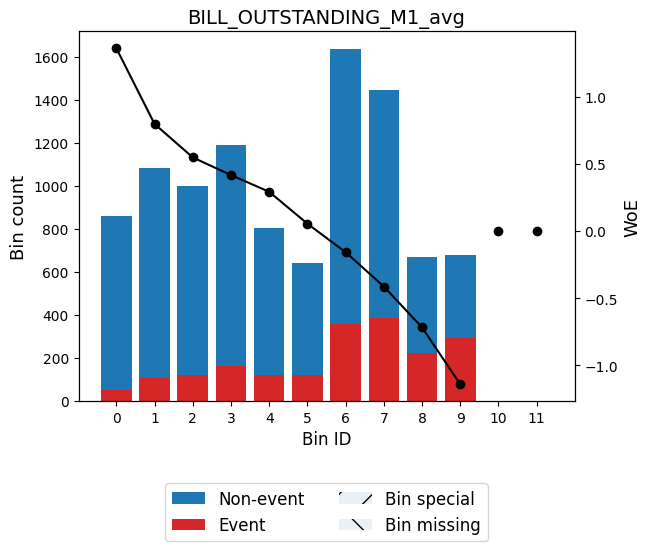

In [295]:
optb.binning_table.plot()

In [196]:
analyze_dtypes(df, 'PORTOUT_N_FLG_norm',['party_id'])

AttributeError: 'DataFrame' object has no attribute 'select'

In [201]:
import pandas as pd
 
# from  pyspark library import 
# SparkSession
from pyspark.sql import SparkSession
 
# Building the SparkSession and name
# it :'pandas to spark'
spark = SparkSession.builder.appName(
  "pandas to spark").getOrCreate()
 
# Create the DataFrame with the help 
# of pd.DataFrame()
data = pd.DataFrame({'State': ['Alaska', 'California',
                               'Florida', 'Washington'],
                      
                     'city': ["Anchorage", "Los Angeles", 
                              "Miami", "Bellevue"]})
 
# create DataFrame
df_spark = spark.createDataFrame(data)
 
df_spark.show()

PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.

In [231]:


variable = 'BILL_OUTSTANDING_M1_avg'
target = 'risk_probability'
x = df[variable].values
y = df[target]
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb.fit(x, y)
binned_vals = opt.transform(x, metric = 'bins')


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [285]:
df

,party_id,risk_probability,high_risk_flag,BILL_OUTSTANDING_M1_avg,BILL_AMT_M1_avg,BILL_RENTALS_M1_avg,BILL_RENTALS_M2_avg,BILL_RENTALS_M3_avg,BILL_RENTALS_M4_avg,BILL_RENTALS_M5_avg,...,VO_MOB_MOU_OFFNT_M1,VO_MOB_MOU_ONNT_M1,MNP_PORT_IN_0_count,MNP_PORT_OUT_0_count,MNP_PORT_IN_1_count,MNP_PORT_OUT_1_count,MNP_PORT_IN_0_norm,MNP_PORT_OUT_0_norm,MNP_PORT_IN_1_norm,MNP_PORT_OUT_1_norm
0,0,0.571403,1,268.446372,264.006126,856.187442,106.633726,193.966126,25.840428,802.650293,...,4620.328203,-7968.835914,-0.434443,0.319619,0.186684,0.500904,-0.145073,0.950817,-0.165370,1.393181
1,1,0.428889,0,1800.409447,-3444.416225,-78.436109,2660.932657,1446.966216,228.388904,452.144613,...,2550.442916,2814.091780,-0.565638,-0.303764,1.132967,-0.129399,-1.696231,-1.875032,-0.702329,0.623256
2,2,0.578091,1,3833.092421,3121.123954,-153.298134,2076.386333,1.342928,340.057485,-357.650378,...,-693.225402,8509.241119,-0.279918,-0.572202,-0.999557,0.390135,-0.834636,0.302802,0.039046,0.064727
3,3,0.206098,0,-4543.636797,2176.991919,45.708916,115.500907,-356.876306,46.263589,207.812790,...,389.037800,1324.512035,-0.837360,0.005788,0.662493,-0.154387,-0.188265,-0.259507,-0.945325,0.823183
4,4,0.813321,1,7897.609149,-4895.840730,387.500954,-780.477241,543.178574,412.299131,369.350706,...,938.169501,28462.713522,0.620698,2.061131,-1.158008,-0.096248,0.882496,-0.477681,0.389453,0.892902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22197,22197,0.913169,1,5321.444742,6836.633476,890.694491,1982.527941,1020.790689,36.187097,431.642738,...,2665.422531,2412.216448,-1.141836,0.965790,0.249711,0.710452,0.178164,-1.093999,-1.044255,-0.942872
22198,22198,0.033452,0,-1258.688470,-1305.889871,-646.204528,1738.562702,-346.192057,412.511291,128.234891,...,767.440736,-8795.882899,0.761985,-0.039071,1.039206,0.158738,-0.458842,1.064775,0.564123,-0.729083
22199,22199,0.727680,1,-4665.073735,1783.343445,-69.216350,525.081634,46.346138,449.556704,182.236692,...,5831.037955,45633.503266,0.195993,-0.512048,1.248387,-1.076009,0.263344,1.658318,-0.892083,0.674188
22200,22200,0.934180,1,4038.891802,8310.516463,392.477704,-433.352319,2194.073844,993.260018,433.082027,...,1068.045261,11146.618579,-0.255205,0.394864,0.968743,0.595261,-1.073915,-0.927437,-0.527395,0.547432


,party_id,risk_probability,high_risk_flag,BILL_OUTSTANDING_M1_avg,BILL_AMT_M1_avg,BILL_RENTALS_M1_avg,BILL_RENTALS_M2_avg,BILL_RENTALS_M3_avg,BILL_RENTALS_M4_avg,BILL_RENTALS_M5_avg,...,VO_MOB_MOU_OFFNT_M1,VO_MOB_MOU_ONNT_M1,MNP_PORT_IN_0_count,MNP_PORT_OUT_0_count,MNP_PORT_IN_1_count,MNP_PORT_OUT_1_count,MNP_PORT_IN_0_norm,MNP_PORT_OUT_0_norm,MNP_PORT_IN_1_norm,MNP_PORT_OUT_1_norm
0,0,0.571403,1,0.378195,0.381739,-0.522778,0.427760,0.242801,0.373784,-1.404675,...,-0.760160,0.720911,0.006189,-0.001185,-0.000962,0.105068,-0.013903,-0.022573,0.000236,-0.078785
1,1,0.428889,0,0.127746,0.890638,0.367063,-0.885988,-0.447916,-0.039780,-0.594313,...,-0.236073,0.213412,0.006189,0.011815,-0.018984,-0.011102,-0.013903,-0.090938,0.000236,0.017173
2,2,0.578091,1,-0.165541,-0.191718,0.505156,-0.390338,0.498996,-0.240624,1.527838,...,0.504573,-0.141884,0.006189,0.006744,-0.059929,0.047632,-0.013903,0.021997,0.000236,0.008300
3,3,0.206098,0,1.345743,-0.027173,0.367063,0.427760,0.498996,0.132893,-0.148281,...,0.344146,0.270919,0.021258,0.179367,-0.000962,-0.011102,-0.013903,0.021997,0.000236,0.017173
4,4,0.813321,1,-0.737869,1.328707,-0.043420,0.736568,0.191383,-0.443189,-0.594313,...,0.189792,-1.103929,-0.027106,-0.034349,-0.059929,-0.011102,-0.030282,-0.015528,-0.037295,0.017173


In [255]:

model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

from sklearn.metrics import classification_report, confusion_matrix

# Calculate precision, recall, F1-score, and support
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.9043008331456879


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.93      0.86      1604
           1       0.00      0.00      0.00       396

    accuracy                           0.75      2000
   macro avg       0.40      0.47      0.43      2000
weighted avg       0.63      0.75      0.69      2000

Confusion Matrix:
 [[1498  106]
 [ 396    0]]


'              precision    recall  f1-score   support\n\n           0       1.00      0.13      0.22      2227\n           1       0.53      1.00      0.69      2214\n\n    accuracy                           0.56      4441\n   macro avg       0.77      0.56      0.46      4441\nweighted avg       0.77      0.56      0.46      4441\n'

In [277]:
accuracy

0.5620355775726188

'2024_04_15_15_46_51'